In [ ]:
# 在这个ipnb中，想要实现 llm + node, 基于langgraph 来实现问题。
# 这种方案相比于 agent直接调用 tool的区别在于，这是一个白盒的过程，我们可以对每一次tool的调用都显式可见。
# 同时也可以设置 tool调用之后的顺序。

# 因此需要完成：
# 1. state的定义
# 2. llm node的定义
# 3. tool node的定义
# 4. graph构建
# 5. 可视化与运行
# 6. 梳理之后 multi-agent的控制逻辑


In [1]:
# 导入必要的包 laggraph , langchain, shenlunchat
import langgraph
import langchain


In [2]:
## 创建 state
from langgraph.graph import StateGraph, START, END
from pydantic import BaseModel, Field
from typing import List, Optional
# 输入已经定义好的state
# input:StudentAnswer, output:StudentAnswerPoints
from ShenlunChat.agents.models.student_answer import  StudentAnswer, StudentAnswerPoints
from typing import TypedDict
class OverallState(BaseModel):
    answer: str = ""
    points: List[str] = []
    valid: bool = False


In [3]:
from ShenlunChat.agents.agent_factory.factory import AgentFactory

# 定义 llm 节点
model_info = {"chat_name":"openai","model_name":"gpt-4o","model_config":{}}
task_info = {"task_name":"split_points","prompt_type":"prompt"}
tool_info = ["check_string_list_in_content"]
llm, parser = AgentFactory.create_agent(model_info,task_info,tool_info,llm=True)
print("create agent success")

def llm_split_node(state:StudentAnswer)->OverallState:
    result = llm.invoke({"content":state.content})
    return {"points":result.check_points, "valid":False,"answer":state.content}



create agent success


In [4]:
# 定义 tool 节点
# from ShenlunChat.agents.models.tool import Tool

def check_result(state:OverallState)->OverallState:
    result = state.points
    origin_string = state.answer
    str_num = 0
    for elem in result:
        if elem in origin_string:
            str_num += len(elem)
    print("str_num",str_num,"total num:",len(origin_string))
    print("rate:",str_num/len(origin_string))
    valid = str_num/len(origin_string) > 0.5
    return {"valid":valid}


In [5]:

graph = StateGraph(input=StudentAnswer,state_schema=OverallState)
graph.add_node(llm_split_node)
graph.add_node(check_result)
graph.add_edge(START,"llm_split_node")
graph.add_edge("llm_split_node","check_result")
graph.add_edge("check_result",END)
graph=graph.compile()


In [6]:
graph.invoke({"content":"1.树立品牌标杆,强化品牌建设，设立质量奖、推广先进经验，将质量文化、品牌理念向全产业链延伸。2.成立行业联盟，制定行业标准，成为区域品牌，3打造一站示公共服务平台。设立指导站，进行专题培训、内容辅导等4.承办先行论坛。发起多项品牌活动。5提供品牌服务。品牌专业组织为制造业企业提供人才培养、品牌培育、战略升维等服务、6、举办高端品牌会议、宣传广东制造，推动企业从“要素竞争”向“品牌竞争“转变"})

str_num 197 total num: 197
rate: 1.0


{'answer': '1.树立品牌标杆,强化品牌建设，设立质量奖、推广先进经验，将质量文化、品牌理念向全产业链延伸。2.成立行业联盟，制定行业标准，成为区域品牌，3打造一站示公共服务平台。设立指导站，进行专题培训、内容辅导等4.承办先行论坛。发起多项品牌活动。5提供品牌服务。品牌专业组织为制造业企业提供人才培养、品牌培育、战略升维等服务、6、举办高端品牌会议、宣传广东制造，推动企业从“要素竞争”向“品牌竞争“转变',
 'points': ['1.树立品牌标杆,强化品牌建设，设立质量奖、推广先进经验，将质量文化、品牌理念向全产业链延伸。',
  '2.成立行业联盟，制定行业标准，成为区域品牌，',
  '3打造一站示公共服务平台。设立指导站，进行专题培训、内容辅导等',
  '4.承办先行论坛。发起多项品牌活动。',
  '5提供品牌服务。品牌专业组织为制造业企业提供人才培养、品牌培育、战略升维等服务、',
  '6、举办高端品牌会议、宣传广东制造，推动企业从“要素竞争”向“品牌竞争“转变'],
 'valid': True}

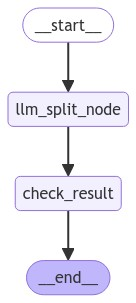

In [7]:
## 图的可视化
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))


In [ ]:
## 接下来 看一下 多任务的情况， 如果将多个任务 采用 multi-agent的形式串联起来。 
## 最好的方式是： gtaph的拼接，将多个graph拼接起来。

from langchain_core.messages import (
    BaseMessage,
    HumanMessage,
    ToolMessage,
)